In [35]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

layer_height = 0.4
layer_count = 12
delta = 0.8

In [2]:
def read_data_file(filename):
    '''
    Read a data file and return a list of polygons.
    Returns:
        polygons = [polygon1, polygon2, polygon3, ...]
        polygon  = [[vertex1, vertex2, ...], [hinge1, hinge2, ...]]
        vertex   = [x, y]
        hinge    = [side_number, hinge_orientation, bending_angle]
    '''
    
    data = []
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()  
            if line and not line.startswith('#'):  
                numbers = [float(x) for x in line.split()]  
                data.append(numbers)
    
    polygons = []
    line = 0
    
    num_polygons = int(data[line][0])
    line += 1
    
    for i in range (num_polygons):
        num_vertices = int(data[line][0])
        num_hinges = int(data[line][1])
        line += 1
        
        vertices = []
        for j in range (num_vertices):
            vertices.append(data[line])
            line += 1
        
        hinges = []
        for j in range (num_hinges):
            hinges.append(data[line])
            line += 1
        
        polygons.append([vertices, hinges])
        
    return polygons

In [3]:
def draw_polygons(polygons):
    """
    Draw the origami pattern represented by the given polygons data.

    Args:
        polygons: from read_data_file
    """

    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    min_x, min_y = float('inf'), float('inf')
    max_x, max_y = float('-inf'), float('-inf')
    for polygon in polygons:
        vertices = polygon[0]
        for x, y in vertices:
            min_x = min(min_x, x)
            min_y = min(min_y, y)
            max_x = max(max_x, x)
            max_y = max(max_y, y)

    ax.set_xlim(min_x - 1, max_x + 1)
    ax.set_ylim(min_y - 1, max_y + 1)

    marked_edges = set()  

    for polygon in polygons:
        vertices = polygon[0]
        highlight_edges = polygon[1]

        for i in range(len(vertices)):
            x1, y1 = vertices[i]
            x2, y2 = vertices[(i + 1) % len(vertices)]
            color = 'black'  
            edge_key = tuple(sorted(((x1, y1), (x2, y2))))  
            text_color = 'black' 

            for edge_info in highlight_edges:
                edge_index = int(edge_info[0]) - 1
                if i == edge_index:
                    color_code = int(edge_info[1])
                    if color_code == 1:
                        color = 'blue'
                    elif color_code == 0:
                        color = 'red'
                    
                    if edge_key not in marked_edges:  
                        value = edge_info[2]  

                        mid_x = (x1 + x2) / 2
                        mid_y = (y1 + y2) / 2

                        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1)) - 90
                        if angle < 0:
                            angle += 360

                        ax.text(mid_x, mid_y, str(value), color=text_color, ha='center', va='center', rotation=angle, fontweight='bold')

                        marked_edges.add(edge_key)  
                        break  
            
            ax.plot([x1, x2], [y1, y2], color=color, linewidth=2)

    plt.title("Origami Pattern")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()

In [52]:
def calculate_b(theta):
    
    t = theta * np.pi / 180 / 2   
    d = layer_height
    h = d * 2
    a = d * (layer_count - 2)
    b = a * np.tan(t) + 1/np.cos(t) * (h - (delta/(t*2) - d/2)*np.sin(t))

    return b

def calculate_width(direction, theta):
    if theta <= 90:
        b = calculate_b(theta)
        w = 2 * b + delta
        if direction == 1:
            w *= -1
        return w
    
    else:
        theta = theta / 2
        b = calculate_b(theta)
        w = 2 * (2 * b + delta) + delta
        if direction == 1:
            w *= -1
        return w

In [57]:
def polygon_array_to_graph(polygon_array):
    """
    将多边形数组转换为无环图，并可视化。
    """

    graph = nx.Graph()
    polygon_count = len(polygon_array)

    # 添加节点（多边形）到图中
    for i in range(polygon_count):
        graph.add_node(i)

    # 找到连接的边并添加到图中
    for i in range(polygon_count):
        for j in range(i + 1, polygon_count):  # 避免重复和自身连接
            polygon1_vertices = polygon_array[i][0]
            polygon1_connections = polygon_array[i][1]
            polygon2_vertices = polygon_array[j][0]
            polygon2_connections = polygon_array[j][1]

            for conn1 in polygon1_connections:
                edge_index1 = int(conn1[0])
                flag1 = conn1[1]  # 获取标志位
                width1 = calculate_width(flag1, conn1[2])  # 使用calculate_width函数

                # 获取 polygon1 的边的顶点坐标
                v1_index1 = (edge_index1 - 1) % len(polygon1_vertices)  # 第一个顶点的索引
                v2_index1 = edge_index1 % len(polygon1_vertices)       # 第二个顶点的索引
                v1 = polygon1_vertices[v1_index1]
                v2 = polygon1_vertices[v2_index1]

                for conn2 in polygon2_connections:
                    edge_index2 = int(conn2[0])
                    flag2 = conn2[1]  # 获取标志位
                    width2 = calculate_width(flag2, conn2[2])  # 使用calculate_width函数

                    # 获取 polygon2 的边的顶点坐标
                    v1_index2 = (edge_index2 - 1) % len(polygon2_vertices)
                    v2_index2 = edge_index2 % len(polygon2_vertices)
                    v3 = polygon2_vertices[v1_index2]
                    v4 = polygon2_vertices[v2_index2]

                    # 比较顶点坐标，判断是否是同一条边
                    # 使用一个容差值来处理浮点数比较
                    tolerance = 0.001
                    if (abs(v1[0] - v3[0]) < tolerance and abs(v1[1] - v3[1]) < tolerance and
                        abs(v2[0] - v4[0]) < tolerance and abs(v2[1] - v4[1]) < tolerance) or \
                       (abs(v1[0] - v4[0]) < tolerance and abs(v1[1] - v4[1]) < tolerance and
                        abs(v2[0] - v3[0]) < tolerance and abs(v2[1] - v3[1]) < tolerance):

                        # 检查宽度是否也一致
                        if abs(width1 - width2) < 0.001:
                            graph.add_edge(i, j, weight=width1)
                            break  # 找到了连接，不再遍历polygon2_connections
                else:
                    continue  # 没有找到匹配的边，继续下一个conn1
                break  # 已经找到一个连接边，不再遍历剩余的边

    # 可视化图形
    pos = nx.spring_layout(graph)  # 可以选择不同的布局算法
    nx.draw(graph, pos, with_labels=True, node_size=1500, node_color="skyblue", font_size=15)
    edge_labels = {(u, v): f"{data['weight']:.3f}" for (u, v, data) in graph.edges(data=True)}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    plt.title("Polygon Connection Graph")
    plt.show()
    return graph

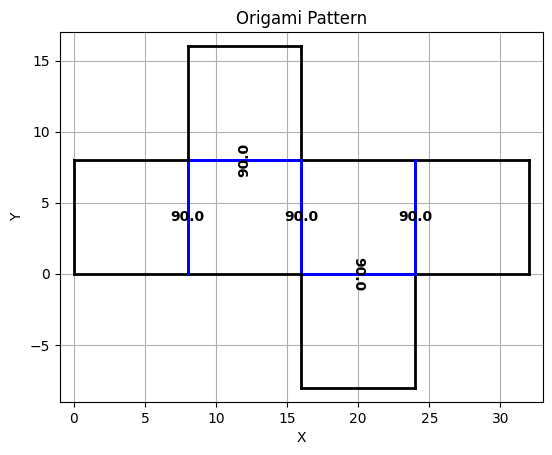

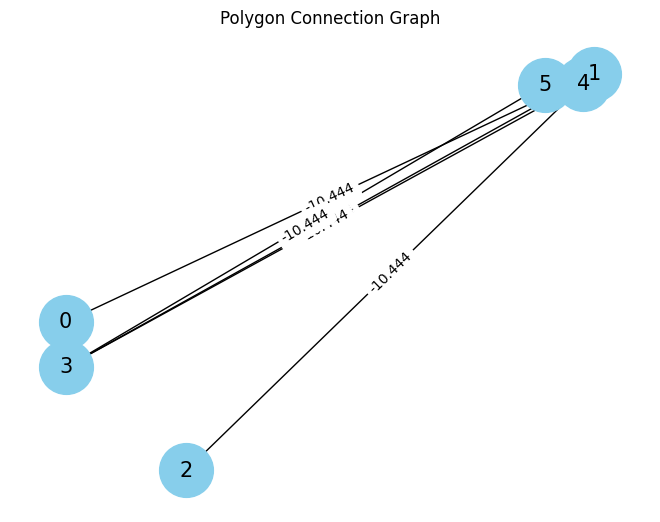

图的边: [(0, 1, {'weight': -10.444150064008822}), (1, 2, {'weight': -10.444150064008822}), (1, 3, {'weight': -10.444150064008822}), (3, 4, {'weight': -10.444150064008822}), (3, 5, {'weight': -10.444150064008822})]


In [71]:
# polygons = read_data_file('data_files/single_90.dat')
# polygons = read_data_file('data_files/single_180.dat')
# polygons = read_data_file('data_files/zig-zag.dat')
polygons = read_data_file('data_files/cube.dat')
draw_polygons(polygons)
graph = polygon_array_to_graph(polygons)
print("图的边:", graph.edges(data=True))

In [74]:
graph.nodes(data=True)

NodeDataView({0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}})